In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import math
from termcolor import colored
plt.style.use("seaborn")

In [2]:
KSI_TO_KPA = 6.89476
IN_TO_M = 0.0254
FT_TO_M = 0.3048
LITRES_TO_M3 = 0.001
G = 9.81                        # m/s^2
RHO = 1000                      # kg/m^3
GAMMA = 9.81                    # kN/m^3
PIPE_DIAMETER = 0.0762          # m
SCALE_PIPE_LENGTH = 3200        # m
MAX_PRESSURE = 448.1594/GAMMA   # m 
MIN_PRESSURE = 275.7904/GAMMA   # m
MIN_FLOW = 0.185                # m^3/s

In [3]:
xlsx = pd.ExcelFile("./lab3_spreadsheet.xlsx")

PN - Pumps with variable speeds
PP - Pumps in Parallel

In [4]:
pipe_info = pd.read_excel(xlsx, "pipe_info")
pipe_info["pipe_diameter"] = pipe_info["pipe_diameter"].apply(lambda x: x*IN_TO_M)
pipe_info["pipe_cost"] = pipe_info["pipe_cost"].apply(lambda x: x/FT_TO_M)
pipe_info.set_index("pipe_diameter", inplace=True)

In [5]:
def preprocess(origin_dataset: pd.DataFrame, pipe_diameter: float):
    dataset = origin_dataset.copy(deep=True)
    dataset["correct_current"] = dataset["current_p1"].apply(lambda x: (x**2*(-0.0347)) + (1.39*x)+0.0266)
    dataset["input_power"] = dataset.apply(lambda rows: rows["correct_current"] * rows["voltage"], axis=1)
    dataset["pressure_p1"] = dataset["pressure_p1"].apply(lambda x: x*KSI_TO_KPA)
    dataset["pressure_head_p1"] = dataset["pressure_p1"].apply(lambda x: x/GAMMA)
    dataset["flow_p1"] = dataset["flow_p1"].apply(lambda x: x*LITRES_TO_M3)
    dataset["velocity_p1"] = dataset["flow_p1"].apply(lambda x: x/(math.pi*(pipe_diameter/2)**2))
    dataset["velocity_head_p1"] = dataset["velocity_p1"].apply(lambda x: (x**2)/(2*G))
    dataset["total_pump_head"] = dataset["velocity_head_p1"] + dataset["pressure_head_p1"]
    dataset["fluid_power"] = dataset.apply(lambda rows: (rows["total_pump_head"]*rows["flow_p1"]*RHO*G), axis=1)
    dataset["efficiency"] = dataset.apply(lambda rows: rows["fluid_power"]/rows["input_power"], axis=1)
    return dataset

In [6]:
def load(excelFile, analysisSheets):
    dfs = {}
    for sheetName in analysisSheets:
        cur_df = pd.read_excel(excelFile, sheetName)
        dfs[sheetName] = preprocess(cur_df, PIPE_DIAMETER)
    return dfs

In [7]:
pn_names = ["PN_3450", "PN_3214", "PN_2898", "PN_2501", "PN_2006", "PN_1604"]
pn_dfs = load(xlsx, pn_names)

In [8]:
def plotModelPumpCurve(data, description):
    for name, df in data.items():
        plt.scatter(df["flow_p1"], df["total_pump_head"], label=name)
    plt.legend(title="Pump Speed", loc='center left', bbox_to_anchor=(1, 0.75))
    plt.title(f"Pump Curve - {description}")
    plt.xlabel("flow (m^3/s)")
    plt.ylabel("total head (m)")
    plt.show()

In [9]:
def plotEfficiencies(data, description):
    for name, df in data.items():
        plt.scatter(df["flow_p1"], df["efficiency"].apply(lambda x: round(x*100, 2)), label=name)
    plt.legend(title="Pump Speed", loc='center left', bbox_to_anchor=(1, 0.75))
    plt.title(f"Pump Efficiency - {description}")
    plt.xlabel("flow (m^3/s)")
    plt.ylabel("Efficiency (%)")
    plt.show()

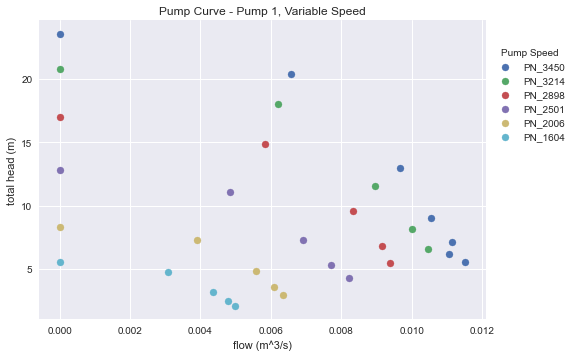

In [10]:
plotModelPumpCurve(pn_dfs, "Pump 1, Variable Speed")

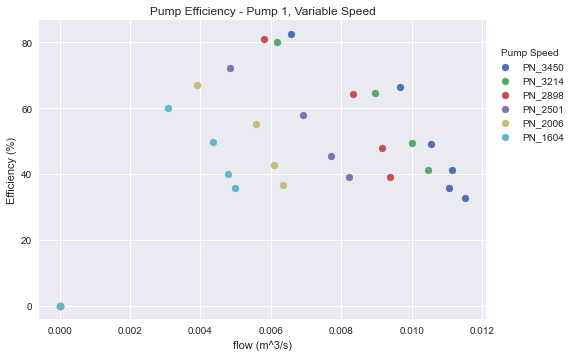

In [11]:
plotEfficiencies(pn_dfs, "Pump 1, Variable Speed")

In [12]:
def generateSystemDemand(f, L, d, Q):
    return (8*f*L)/((math.pi**2)*G*d**5)*Q**2

In [13]:
def scalePump(data, n2, d1, d2, f, L):
    dfs = {}
    for name, df in data.items():
        n1 = int(name.split("_")[1])
        new_df = pd.DataFrame(columns=["flow", "total_pump_head", "fluid_power", "efficiency", "input_power", "system_demand"])
        new_df["flow"] = df["flow_p1"].apply(lambda x: x*((d2/d1)**3)*n2/n1)
        new_df["total_pump_head"] = df["total_pump_head"].apply(lambda x: x*((n2/n1)**2)*(d2/d1)**2)
        new_df["fluid_power"] = df["fluid_power"].apply(lambda x: (((n2/n1)**3)*(d2/d1)**5)*x)
        new_df["efficiency"] = df["efficiency"].apply(lambda x: (((1-x)/((d2/d1)**(1/5)))-1)*-1)
        new_df["input_power"] = new_df["fluid_power"]/new_df["efficiency"]
        new_df["system_demand"] = new_df["flow"].apply(lambda x: generateSystemDemand(f, L, d2, x))
        dfs[name] = new_df
    return dfs

In [14]:
def plotPumpCurve(scaledData, scaledSpeed, extrapolate=False, suppressGraphs=False):
    inter_data = {"scaled_n1":[], "flow":[], "head":[]}
    for i, (name, df) in enumerate(scaledData.items()):
        n1 = int(name.split("_")[1])
        poly_func_head = Polynomial.fit(df["flow"], df["total_pump_head"], 2)
        poly_func_sysd = Polynomial.fit(df["flow"], df["system_demand"], 2)
        if extrapolate:
            # increase maximum x-range domain to ensure intersection
            poly_xvals = np.linspace(df["flow"].min(), df["flow"].max()+(df["flow"].max()*0.10), 50)
        else:
            poly_xvals = np.linspace(df["flow"].min(), df["flow"].max(), 50)
        poly_yvals_head = poly_func_head(poly_xvals)
        poly_yvals_sysd = poly_func_sysd(poly_xvals)
        try:
            finiteDifferences = np.diff(np.sign(poly_yvals_head - poly_yvals_sysd))
            if not np.any(finiteDifferences):
                raise ValueError(f"{i}. Pump curve and system demand curve do not intersect at scaled pump station of n1={n1}.")
            common_idx = np.argwhere(finiteDifferences).flatten()[0]
            print(f"{i}. Point of intersection - flow (m^3/s):{round(poly_xvals[common_idx], 3)}, head (m): {round(poly_yvals_head[common_idx], 3)}")
            inter_data["scaled_n1"].append(n1)
            inter_data["flow"].append(round(poly_xvals[common_idx], 3))
            inter_data["head"].append(round(poly_yvals_head[common_idx], 3))
        except ValueError as err:
            print(err)
            inter_data["scaled_n1"].append(n1)
            inter_data["flow"].append(round(None))
            inter_data["head"].append(round(None))
        if not suppressGraphs:
            plt.plot(poly_xvals, poly_yvals_head, label="total pump head")
            plt.plot(poly_xvals, poly_yvals_sysd, color="orange", label="system demand")
            plt.title(f"Pump Curve - Scaled Speed: {scaledSpeed} rpm; Model Speed: {n1}")
            plt.legend(title="Pump Speed", loc='center left', bbox_to_anchor=(1, 0.75))
            plt.ylabel("head (m)")
            plt.xlabel("flow (m^3/s)")
            plt.show()
    return pd.DataFrame(inter_data)

In [15]:
def main(model_dataset, pipe_diameters, n2, d1, d2, suppressGraphs=False):
    for d in pipe_diameters:
        scl_dfs = scalePump(model_dataset, n2, d1, d2, 0.0125, SCALE_PIPE_LENGTH)
        print(f"Scaled Pump Curves - Pipe Diameter = {round(d, 3)}".center(52, "-"))
        exp_cost = SCALE_PIPE_LENGTH * pipe_info.loc[d, "pipe_cost"]
        print(f"Expected cost = ${round(exp_cost, 2)}")
        intersection = plotPumpCurve(scl_dfs, 3450, True, suppressGraphs)
        print(f"Satisfactory?:")
        print(colored("max pressure - Pass!", "green")) if (intersection["head"] < MAX_PRESSURE).all() else print(colored("max pressure - Fail!", "red"))
        print(colored("min pressure - Pass!", "green")) if (intersection["head"] > MIN_PRESSURE).all() else print(colored("min pressure - Fail!", "red"))
        print(colored("min flow - Pass!", "green")) if (intersection["flow"] > MIN_FLOW).all() else print(colored("min pressure - Fail!", "red"))
        print(intersection)

In [16]:
pipe_info.index

Float64Index([             0.1016, 0.15239999999999998,              0.2032,
              0.30479999999999996,               0.381,              0.4572,
               0.6095999999999999,               0.762,              0.9144,
                           1.0668,  1.2191999999999998],
             dtype='float64', name='pipe_diameter')

-----Scaled Pump Curves - Pipe Diameter = 0.102-----
Expected cost = $13858.27
0. Point of intersection - flow (m^3/s):0.081, head (m): 14.499


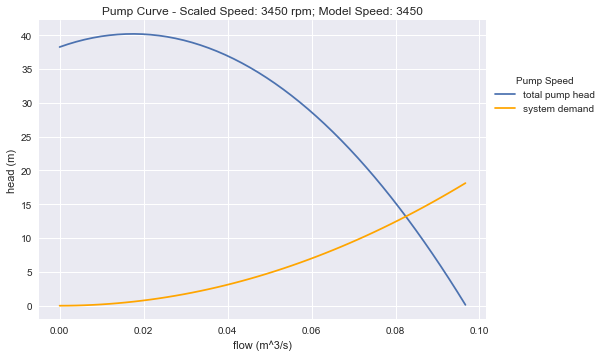

1. Point of intersection - flow (m^3/s):0.083, head (m): 14.73


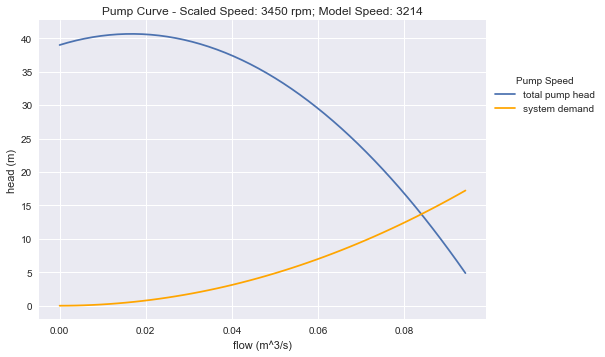

2. Point of intersection - flow (m^3/s):0.084, head (m): 14.444


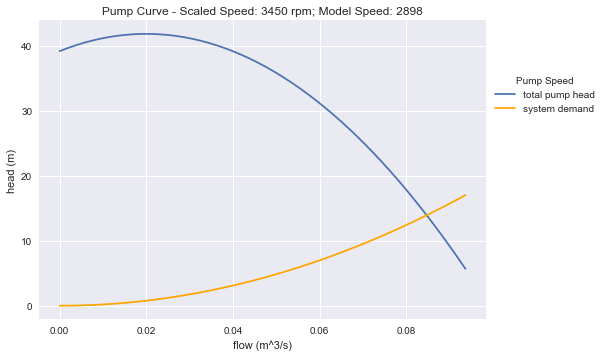

3. Point of intersection - flow (m^3/s):0.083, head (m): 15.17


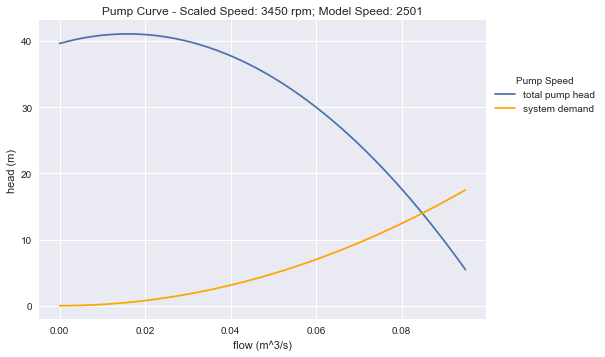

4. Point of intersection - flow (m^3/s):0.084, head (m): 13.919


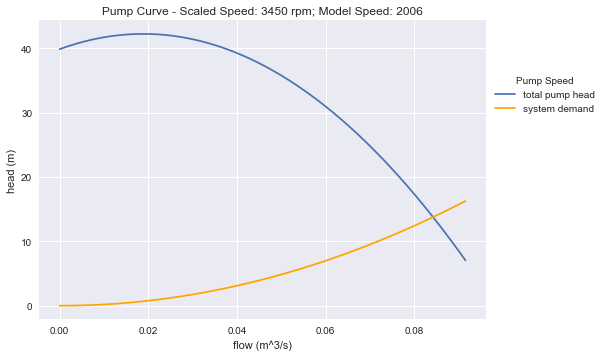

5. Point of intersection - flow (m^3/s):0.082, head (m): 15.095


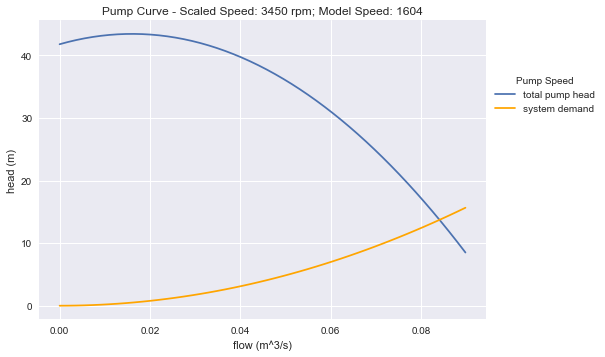

Satisfactory?:
max pressure - Pass!
min pressure - Fail!
min pressure - Fail!
   scaled_n1   flow    head
0       3450  0.081  14.499
1       3214  0.083  14.730
2       2898  0.084  14.444
3       2501  0.083  15.170
4       2006  0.084  13.919
5       1604  0.082  15.095


In [17]:
main(pn_dfs, [0.1016], 1800, 0.1143, 11*IN_TO_M)